# Transformada de Hough para círculos 
Feito por: Derick Teles Chagas

Este notebook ilustra a implementação **ingênua** da Transformada de Hough para detecção de círculos em uma imagem.

## Objetivos
1. Carregar uma imagem e convertê-la para escala de cinza.
2. Extrair as bordas com o filtro Sobel.
3. Binarizar a imagem (threshold).
4. Aplicar operações morfológicas (fechamento/abertura) para limpar ruídos.
5. Implementar a **Transformada de Hough Circular** ingênua para um raio fixo.
6. Visualizar a **grade de acumuladores** (2D) para esse raio.
7. Identificar os picos no acumulador (centros prováveis).
8. Desenhar as circunferências detectadas sobre a imagem original.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2gray, gray2rgb
from skimage.filters import sobel
from skimage.morphology import binary_opening, binary_closing
from skimage.draw import circle_perimeter
import math

def CHT(img_bin, radius):
    """
    Implementação ingênua da Transformada de Hough para círculos com um único raio.
    Para cada pixel de borda (valor 1) da imagem binária, varre 360° e acumula votos 
    para os possíveis centros de círculos de raio 'radius'.      
    """
    H, W = img_bin.shape
    acumulador = np.zeros((H, W), dtype=np.uint64)
    angulos = np.deg2rad(np.arange(0, 360, 1))
    cos_angulos = np.cos(angulos)
    sin_angulos = np.sin(angulos)
    
    edge_y, edge_x = np.nonzero(img_bin)
    
    # Para cada pixel de borda, vote para todos os ângulos
    for y, x in zip(edge_y, edge_x):
        # Calcula os centros candidatos:
        a_candidatos = np.rint(x - radius * cos_angulos).astype(int)
        b_candidatos = np.rint(y - radius * sin_angulos).astype(int)
        # Atualiza o acumulador apenas se o centro candidato estiver na imagem
        for a, b in zip(a_candidatos, b_candidatos):
            if 0 <= a < W and 0 <= b < H:
                acumulador[b, a] += 1
    return acumulador

def hough_circle_peaks(acumulador, total_num_peaks=10, threshold=None, tamVizinhanca=8):
    """
    Encontra os picos (centros prováveis) na grade de acumuladores
    """
    H, W = acumulador.shape
    if threshold is None:
        threshold = 0.5 * acumulador.max()
    
    # Lista de candidatos (valor, y, x)
    candidatos = []
    for y in range(H):
        for x in range(W):
            if acumulador[y, x] >= threshold:
                candidatos.append((acumulador[y, x], y, x))
    
    # Ordena os candidatos em ordem decrescente (maior valor primeiro)
    candidatos.sort(key=lambda c: c[0], reverse=True)
    
    selecionados = []
    for val, y, x in candidatos:
        if len(selecionados) >= total_num_peaks:
            break
        # Supressão não-máxima: descarta candidatos muito próximos
        muito_proximo = False
        for _, sel_y, sel_x in selecionados:
            if abs(y - sel_y) < tamVizinhanca and abs(x - sel_x) < tamVizinhanca:
                muito_proximo = True
                break
        if not muito_proximo:
            selecionados.append((val, y, x))
    
    valores_acumulador = [s[0] for s in selecionados]
    centers_y = [s[1] for s in selecionados]
    centers_x = [s[2] for s in selecionados]
    
    return valores_acumulador, centers_y, centers_x

## 1) Carregando a imagem e convertendo para escala de cinza

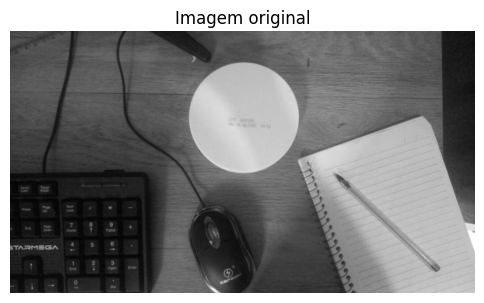

In [3]:
# Ajuste o nome do arquivo conforme necessário
img = imread("imagemPIMG2.jpeg")  

if img.ndim == 3:
    img_gray = rgb2gray(img)
else:
    img_gray = img.astype(float)

plt.figure(figsize=(6,6))
plt.imshow(img_gray, cmap='gray')
plt.title("Imagem original")
plt.axis("off")
plt.show()

## 2) Extração de bordas

A circunferência é a borda do círculo, então usamos o gradiente (Sobel) para realçar essas bordas.

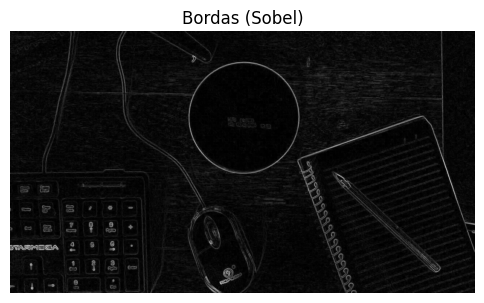

In [4]:
edges = sobel(img_gray)
plt.figure(figsize=(6,6))
plt.imshow(edges, cmap='gray')
plt.title("Bordas (Sobel)")
plt.axis("off")
plt.show()

## 3) Binarização

Como a CHT opera sobre imagens binárias, precisamos limiarizar a imagem de bordas.

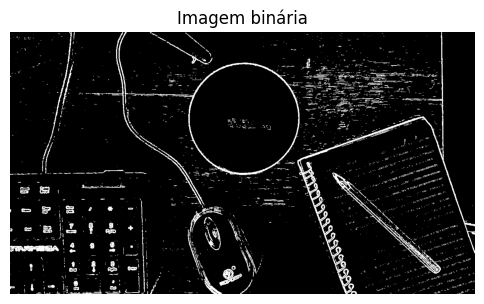

In [5]:
# Exemplo: limiar = image.max() * (10/256), como no notebook do professor
limiar = img_gray.max() * (10/256)
binary = edges.copy()
binary[binary <= limiar] = 0
binary[binary > 0] = 1

plt.figure(figsize=(6,6))
plt.imshow(binary*255, cmap='gray')
plt.title("Imagem binária")
plt.axis("off")
plt.show()

## 4) Emprego de operadores morfológicos

A abertura e o fechamento são aplicadas para remover ruídos (grãos e buracos), tornando a imagem binária mais homogênea.

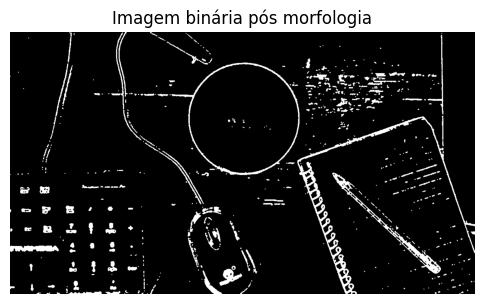

In [6]:
binary = binary_closing(binary)
binary = binary_opening(binary)
plt.figure(figsize=(6,6))
plt.imshow(binary, cmap='gray')
plt.title("Imagem binária pós morfologia")
plt.axis("off")
plt.show()

## 5) Chamada da CHT  para um raio fixo

Como a CHT ingênua gera uma grade 2D (pois usamos **um** raio), faremos a varredura de 0 a 359 graus para cada pixel de borda.

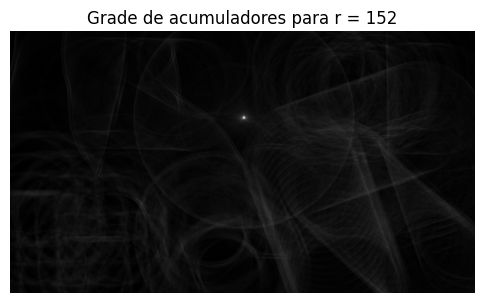

In [7]:
# Raio ajustável
raio_fixo = 152  
acumulador = CHT(binary, raio_fixo)

plt.figure(figsize=(6,6))
plt.imshow(acumulador, cmap='gray')
plt.title(f"Grade de acumuladores para r = {raio_fixo}")
plt.axis("off")
plt.show()

## 6) Obtenção dos centros

Uma filtragem para obter as circunferências mais importantes é aplicada com base na função auxiliar que seleciona apenas os picos da CHT.

In [8]:
total_num_peaks = 6
valores_acumulador, centers_y, centers_x = hough_circle_peaks(
    acumulador,
    total_num_peaks=total_num_peaks,
    threshold=None, 
    tamVizinhanca=15    # supressão de picos próximos
)

print("Valores de acumulador nos picos:", valores_acumulador)
print("Coordenadas Y:", centers_y)
print("Coordenadas X:", centers_x)

Valores de acumulador nos picos: [np.uint64(360)]
Coordenadas Y: [237]
Coordenadas X: [643]


## 7) Desenho das circunferências

Por fim, desenhamos as circunferências detectadas sobre a imagem original, convertendo a escala de cinza para RGB para podermos colorir.

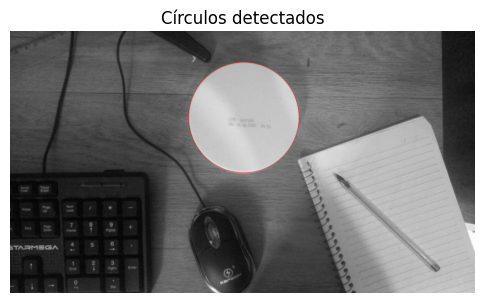

In [9]:
image_color = gray2rgb(img_gray)  # converte para RGB

for (cy, cx) in zip(centers_y, centers_x):
    rr, cc = circle_perimeter(cy, cx, raio_fixo, shape=img_gray.shape)

    image_color[rr, cc] = (1, 0, 0)

plt.figure(figsize=(6,6))
plt.imshow(image_color)
plt.title("Círculos detectados")
plt.axis("off")
plt.show()